In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns 
%matplotlib inline

In [2]:
def renameBranchesName(dfResults,branchColumnName):
    
    netexits = list(dfResults[branchColumnName].unique())
    
    mainInList = 'main' in netexits
    
    if mainInList:
        netexits.remove('main')
    netexits.sort()
    d = dict((value, idx+1) for (idx, value) in enumerate(netexits))
    
    if mainInList:
        d['main'] = 'main'
        
    dfResults['exit'] = dfResults[branchColumnName].map(d)

In [3]:
def createAndSaveRunningResultsGraph(dfResults,parameterResult,gTitle,ouputFolder):
    plt.figure(figsize=(20,10))
    
    netexits = list(dfResults.exit.unique())
    
    for exit in netexits:
        dfResultsByexit = dfResults[dfResults['exit']==exit]
        plt.plot( 'epoch', parameterResult, data=dfResultsByexit, label='Exit branch: ' + str(exit))

    plt.xlabel('Epoch', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel(parameterResult, fontsize=25)
    plt.yticks(fontsize=20)
    plt.title(gTitle, fontsize=35)
    #plt.legend()
    plt.legend(fontsize='medium',prop={'size': 18})

    plt.savefig(ouputFolder + '/' + gTitle + '.png')   # save the figure to file


In [4]:
def casesByExitGraph(dfResults,gTitle,ouputFolder):
    
    dfResults2 = dfResults.copy()
    dfResults2 = dfResults2.round(3)
    netexits = list(dfResults2.exit.unique())
    thresholds = list(dfResults2.threshold.astype(str).unique())
    
    index = np.arange(len(thresholds))
    
    plt.figure(figsize=(20,10))
    
    bar_width = 0.35
    opacity = 0.8
    
    
    casesTotal = dfResults2['casesToEval'].sum()/len(thresholds)
    dfResults2['casesToEval'] = dfResults2['casesToEval']/casesTotal
    
    for idx, exit in enumerate(netexits):
        dfResultsByexit = dfResults2[dfResults2['exit']==exit]
        #dfResultsByexit['casesToEval']
        plt.bar(index + bar_width*idx, dfResultsByexit['casesToEval'], bar_width,
                     alpha=opacity,
                     label='Exit branch: ' + str(exit))

    plt.xlabel('Threshold', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel('Exits', fontsize=25)
    plt.yticks(fontsize=20)
    plt.title(gTitle, fontsize=35)
    
    
    
    plt.xticks(index+bar_width/2, thresholds)
    
    plt.legend(fontsize='medium',prop={'size': 18})
    plt.tight_layout()
    
    plt.savefig(ouputFolder +'/Evaluations in each exit.png')   # save the figure to file

In [5]:
def evalAccuracy(dfResults,ouputFolder):
    plt.figure(figsize=(20,10))
    
    netexits = list(dfResults.exit.unique())
    thresholds = list(dfResults.threshold.unique())
    
    combinedAccuracyByThreshold = {}
    
    dfResults2 = dfResults.copy()
    
    
    
    for t in thresholds:
        dfResultsByThreshold = dfResults2[dfResults2['threshold']==t]
        combinedAccuracyByThreshold[t] = (dfResultsByThreshold['casesToEval']*dfResultsByThreshold['accuracyToEval']).sum()/100
                
    casesTotal = dfResults2['casesToEval'].sum()/len(thresholds)
    
    dfResults2['evalCasesPerExitAndThreshold'] = dfResults2['casesToEval']/casesTotal
    
    dfResults2['combinedAccuracy'] = dfResults2['threshold'].map(combinedAccuracyByThreshold)
    dfResults2['combinedError'] = 1-dfResults2['combinedAccuracy']/100
    dfResults2['errorToEval'] = np.where(dfResults2['casesToEval']>0, 1-dfResults2['accuracyToEval']/100, 0)
    
    for idx, exit in enumerate(netexits):
        dfResultsByexit = dfResults2[dfResults2['exit']==exit]
        plt.plot( 'threshold', 'errorToEval', marker="x", data=dfResultsByexit, label='Exit branch: ' + str(exit) + ' error',markersize=18)
        if exit != 'main':
            plt.plot( 'threshold', 'evalCasesPerExitAndThreshold', marker="^", 
                        data=dfResultsByexit, label='Exit branch: ' + str(exit)+' evaluations',markersize=18)
        
    plt.plot( 'threshold', 'combinedError', marker="h", data=dfResults2, label='Combined accuracy',markersize=18)

    plt.xlabel('Threshold', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel('Error', fontsize=25)
    plt.yticks(fontsize=20)
    plt.title('Error By Threshold On Each Exit', fontsize=35)
    plt.legend(fontsize='medium',prop={'size': 18})


    plt.savefig(ouputFolder + '/Error By Threshold On Each Exit.png')   # save the figure to file

In [6]:
def evalAccuracyNoGroundTruth(dfResults,gTitle,ouputFolder):
    plt.figure(figsize=(20,10))
    
    accVsCompDF = pd.DataFrame(columns=['accuracy','compCost'])
    netexits = list(dfResults.exit.unique())
    thresholds = list(dfResults.threshold.unique())
    
    dfResults= evalResults.copy()
    dfResults.round(3)
    
    netexits = list(dfResults.exit.unique())
    thresholds = list(dfResults.threshold.unique())
    
    dfResults2 = dfResults.copy()
    
    df3 = dfResults2[dfResults2['threshold'] == thresholds[0]]
    casesTotal = df3['casesToEval'].sum()
    
    dfMain = dfResults2[dfResults2['path']=='main']
    
    totalComputationCost = dfMain['pathComputationCost'].mean()*casesTotal
    
    computationCostReductionByThreshold = {}
    
    for t in thresholds:
        dfResultsByT = dfResults2[dfResults2['threshold']==t]
        #calulate the computation cost reduction
        
        computationCostReduction = 0
        
        for idx, exit in enumerate(netexits):
            
            dfResultsByExit = dfResultsByT[dfResultsByT['exit']==exit]
            
            pathComputationCost = dfResultsByExit['pathComputationCost'].mean()
            pathCases = dfResultsByExit['casesToEval'].mean()
            
            computationCost = pathComputationCost*pathCases
            
            computationCostReduction = computationCostReduction + computationCost
        
        computationCostReduction = 1 - computationCostReduction/totalComputationCost
        #print(t)
        computationCostReductionByThreshold[t] = computationCostReduction
    
    dfResults2['computationCostReduction'] = dfResults2['threshold'].map(computationCostReductionByThreshold)
    
    dfResults2['accuracyToEval'] = dfResults2['accuracyToEval']/100
    dfResults2['accuracyToEval'] = np.where(dfResults2['accuracyToEval'] > 0, dfResults2['accuracyToEval'], 1)
    
    for idx, exit in enumerate(netexits):
        dfResultsByexit = dfResults2[dfResults2['exit']==exit]
        if exit != 'main':
            plt.plot( 'threshold', 'accuracyToEval', marker="^", 
                        data=dfResultsByexit, label='Exit: ' + str(exit)+' accuracy',markersize=12)
            yValues = dfResultsByexit['accuracyToEval']
            #accVsCompDF['accuracy'] = yValues
        else:
            plt.plot( 'threshold', 'computationCostReduction', marker="x", data=dfResultsByexit, label='Computation cost reduction',markersize=12)
            yValues = dfResultsByexit['computationCostReduction']
            #accVsCompDF['compCost'] = yValues
            
        utils = 1
        for x,y in zip(thresholds, yValues):                                       # <--
            plt.annotate('{:.3f}'.format(y), xy=(x,y+0.02*utils),fontsize=12) # <--
            utils = -utils
        
        
    plt.xlabel('threshold', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel('Accuracy/Computation Cost Reduction', fontsize=25)
    plt.yticks(fontsize=20)
    plt.title(gTitle, fontsize=28)
    plt.legend(fontsize='medium',prop={'size': 18})
    

    plt.savefig(ouputFolder + '/Computation cost reduction.png')   # save the figure to file
    
    dfResultsByexit = dfResults2[dfResults2['exit']==1]
    return dfResults2

In [7]:
def evalAccuracyAndCertScore(dfResults,ouputFolder,gTitle):
    plt.figure(figsize=(20,10))
    
    netexits = list(dfResults.exit.unique())
    
    dfResults2 = dfResults.copy()
    
    dfResults2['avgCertainty'] = dfResults2['avgCertainty']*100
    dfResults2['avgScore'] = (dfResults2['accuracy']+dfResults2['certScore'])/2
    
    parameterResults = ['accuracy','avgCertainty','certScore','avgScore']
    
    parameterLabels = {'accuracy':'Classification accuracy',
                       'avgCertainty': 'Certainty average',
                       'certScore':'Certainty score',
                       'avgScore': 'Average score'}
    for parameterResult in parameterResults:
        for exit in netexits:
            dfResultsByexit = dfResults2[dfResults2['exit']==exit]
            plt.plot( 'epoch', 
                     parameterResult, 
                     data=dfResultsByexit, 
                     label='Exit branch: ' + str(exit) + ' ' + parameterLabels[parameterResult])

    plt.xlabel('Epoch', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel('Score', fontsize=25)
    plt.yticks(fontsize=20)
    #plt.legend()
    plt.title(gTitle, fontsize=35)
    plt.legend(fontsize='medium',prop={'size': 18})

    plt.savefig(ouputFolder + '/' + gTitle +'.png')   # save the figure to file
    
    

In [27]:
def accuracyVsComputation(dfList,gTitle,ouputFolder):
    plt.figure(figsize=(20,10))
    
    lossFDesc = ['Certainty Reg','Certainty Binary','Balance']
    lossFId = 0
    for df in dfList:
            df = df[df['exit']==1]
            df['computation'] = 1-df['computationCostReduction']
            plt.plot( 'computation',
                     'combinedAcc',    
                     marker="x",
                     markersize=15,
                     data=df, 
                     label='Loss function: ' + lossFDesc[lossFId])
            lossFId = lossFId + 1

    plt.xlabel('Computation', fontsize=25)
    plt.xticks(fontsize=20)
    plt.ylabel('Combined Accuracy', fontsize=25)
    plt.yticks(fontsize=20)
    #plt.legend()
    plt.title(gTitle, fontsize=35)
    plt.legend(fontsize='medium',prop={'size': 18})

    plt.savefig(ouputFolder + '/' + gTitle +'.png')   # save the figure to file

In [9]:
#Upload LeNet files
def LeNetLoss1Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\LeNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190501-215114',
           path + '\TestRunning\ExportRunningData 20190501-215114',
           path + '\EvalResults\ExportEvalData 20190502-182720',
           path + '\Graphs']

In [10]:
def LeNetLoss2Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 2 main to certainty\LeNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190501-224451',
           path + '\TestRunning\ExportRunningData 20190501-224451',
           path + '\EvalResults\ExportEvalData 20190502-182755',
           path + '\Graphs']

In [11]:
def LeNetLoss3Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 3 main to certainty\LeNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190501-205622',
           path + '\TestRunning\ExportRunningData 20190501-205622',
           path + '\EvalResults\ExportEvalData 20190502-182829',
           path + '\Graphs']

In [12]:
def AlexNetLoss1Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190412-140641',
           path + '\TestRunning\ExportRunningData 20190412-140641',
           path + '\EvalResults\ExportEvalData 20190502-181532',
           path + '\Graphs']

In [13]:
def AlexNetLoss2Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 2 main to certainty\AlexNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190501-082117',
           path + '\TestRunning\ExportRunningData 20190501-082117',
           path + '\EvalResults\ExportEvalData 20190502-182153',
           path + '\Graphs']

In [14]:
def AlexNetLoss3Files():
    
    path = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 3 main to certainty\AlexNetBranch no ground truth'
    return [path + '\TrainRunning\ExportRunningData 20190501-060619',
           path + '\TestRunning\ExportRunningData 20190501-060619',
           path + '\EvalResults\ExportEvalData 20190502-182402',
           path + '\Graphs']

In [15]:
def fileList(net,lossFunc):
    files = []
    if lossFunc==0 and net == 0:
        files = LeNetLoss1Files()
    if lossFunc==1 and net == 0:
        files = LeNetLoss2Files()
    if lossFunc==2 and net == 0:
        files = LeNetLoss3Files()
    if lossFunc==0 and net == 1:
        files = AlexNetLoss1Files()
    if lossFunc==1 and net == 1:
        files = AlexNetLoss2Files()
    if lossFunc==2 and net == 1:
        files = AlexNetLoss3Files()
            
    return files
        

In [46]:
print(fileList(1,0)[0])

C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth\TrainRunning\ExportRunningData 20190412-140641


'C:\\Yael Codes\\Pyhton\\FinalProject\\Results\\Loss function 1 main to certainty\\AlexNetBranch no ground truth\\Graphs'

In [16]:
netsDesc = ['LeNet', 'AlexNet']
lossFDesc = ['Certainty Reg','Certainty Binary','Balance']

C:\Users\yael_\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001
0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001
0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001
0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001
0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001
0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001


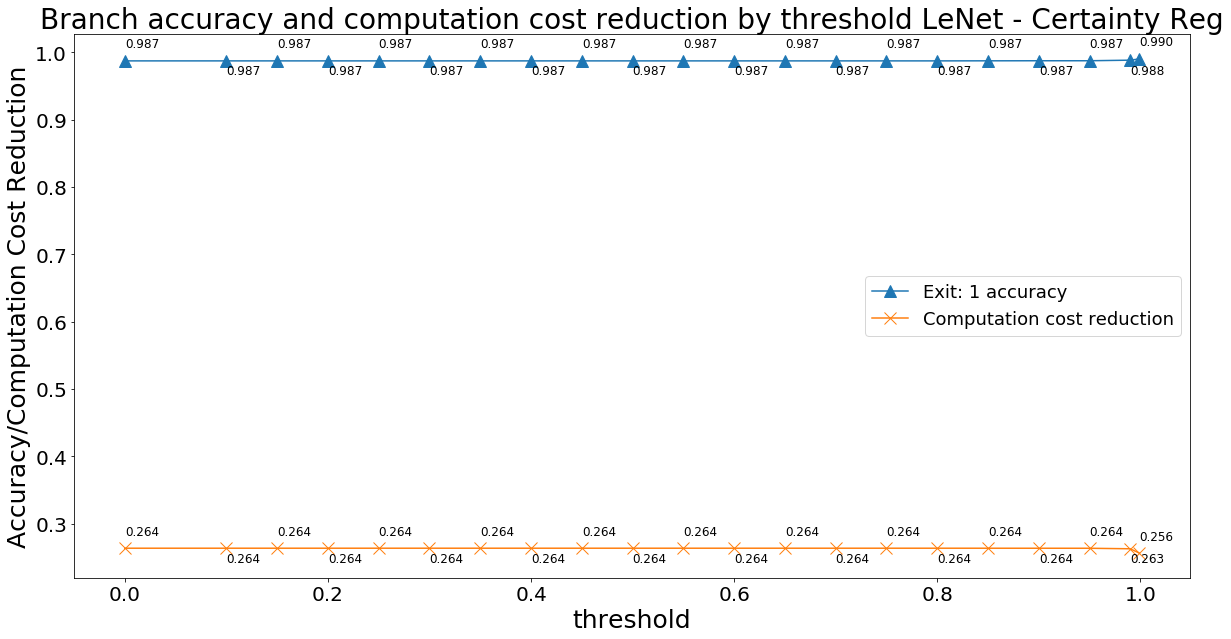

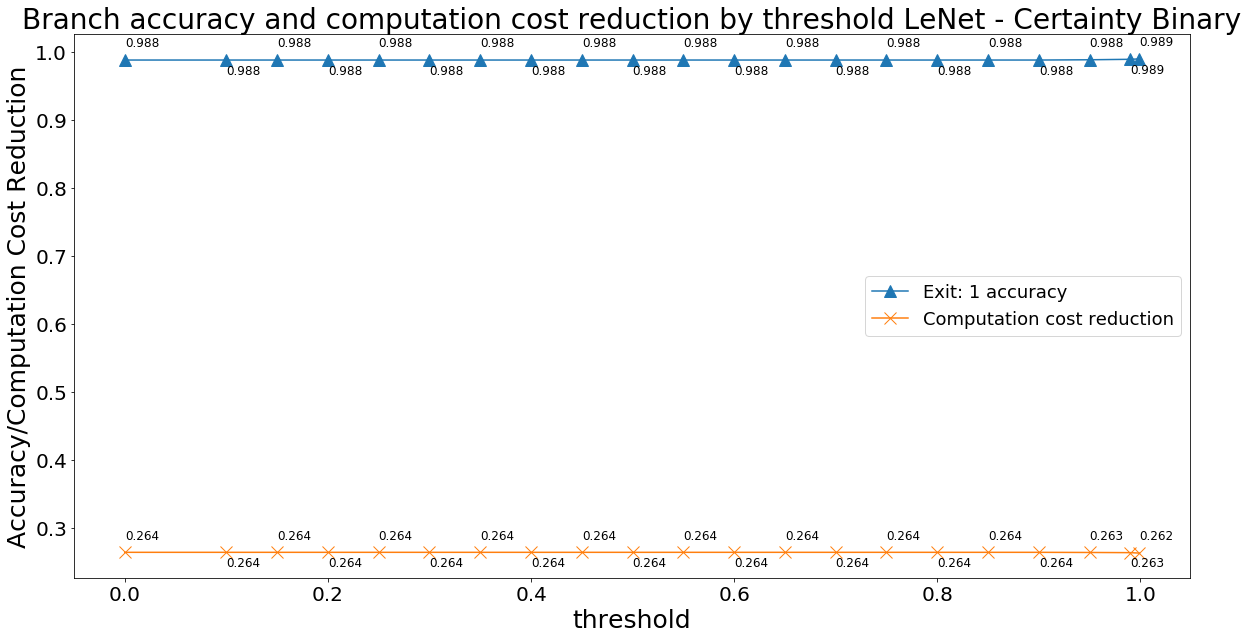

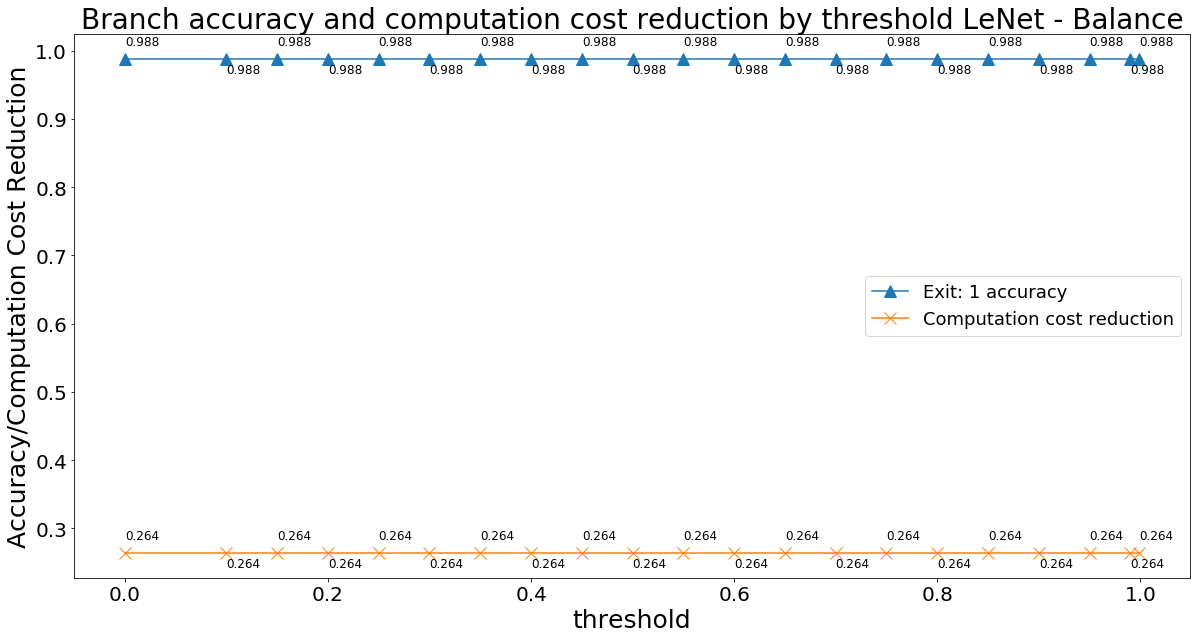

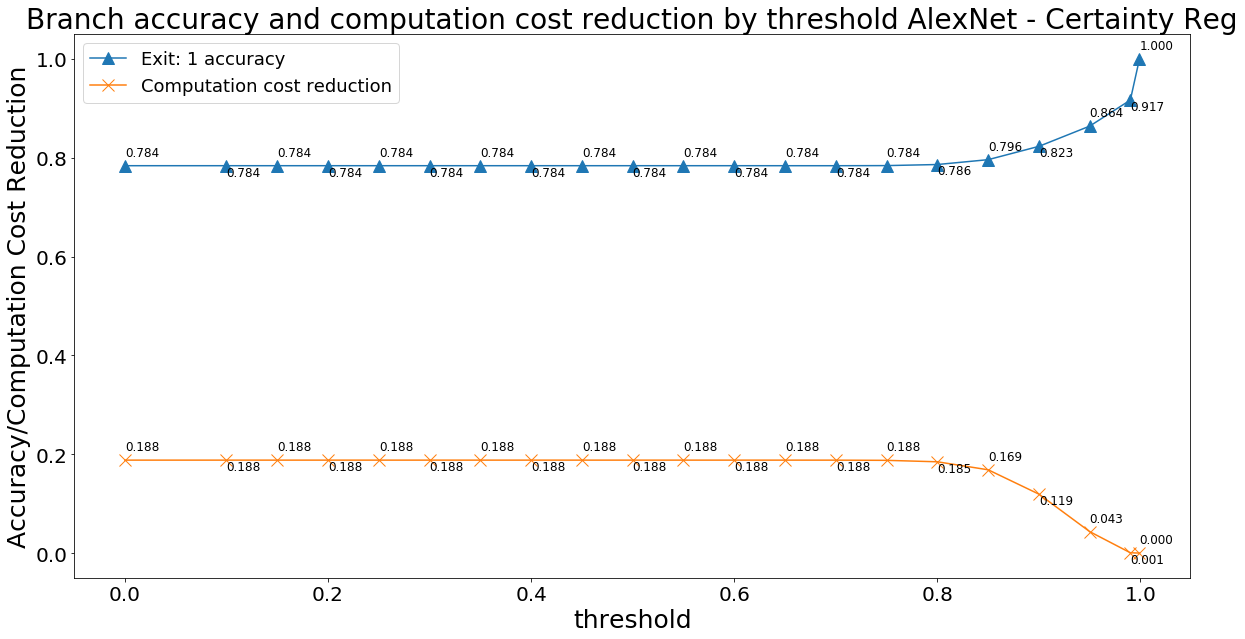

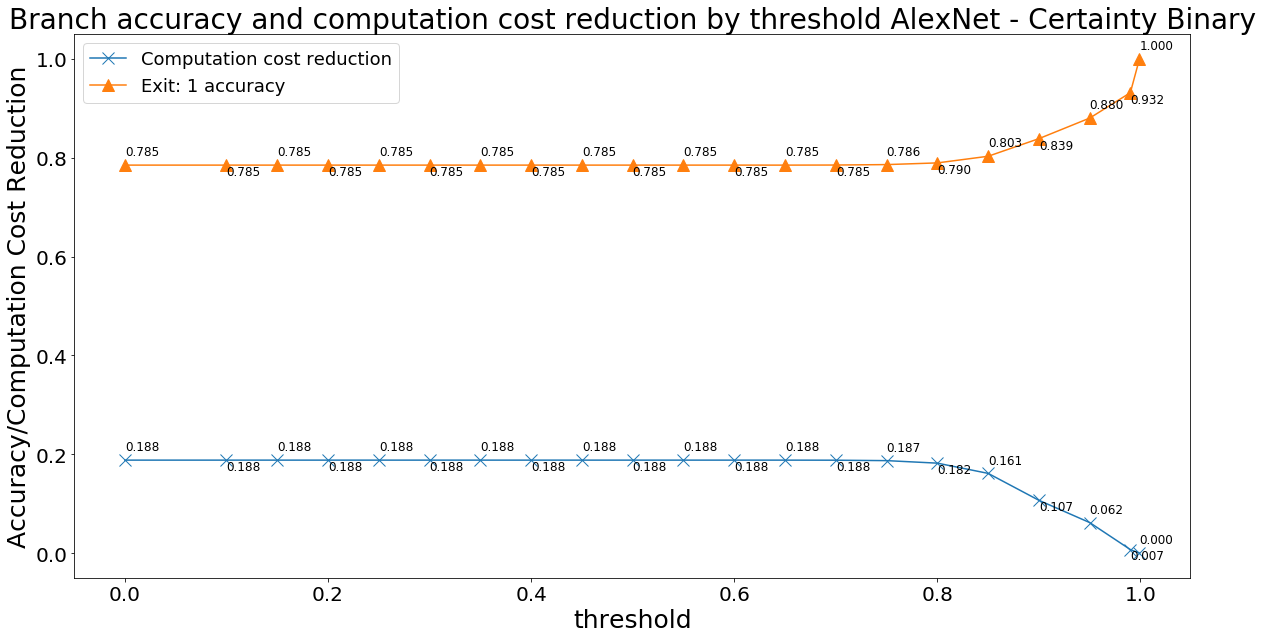

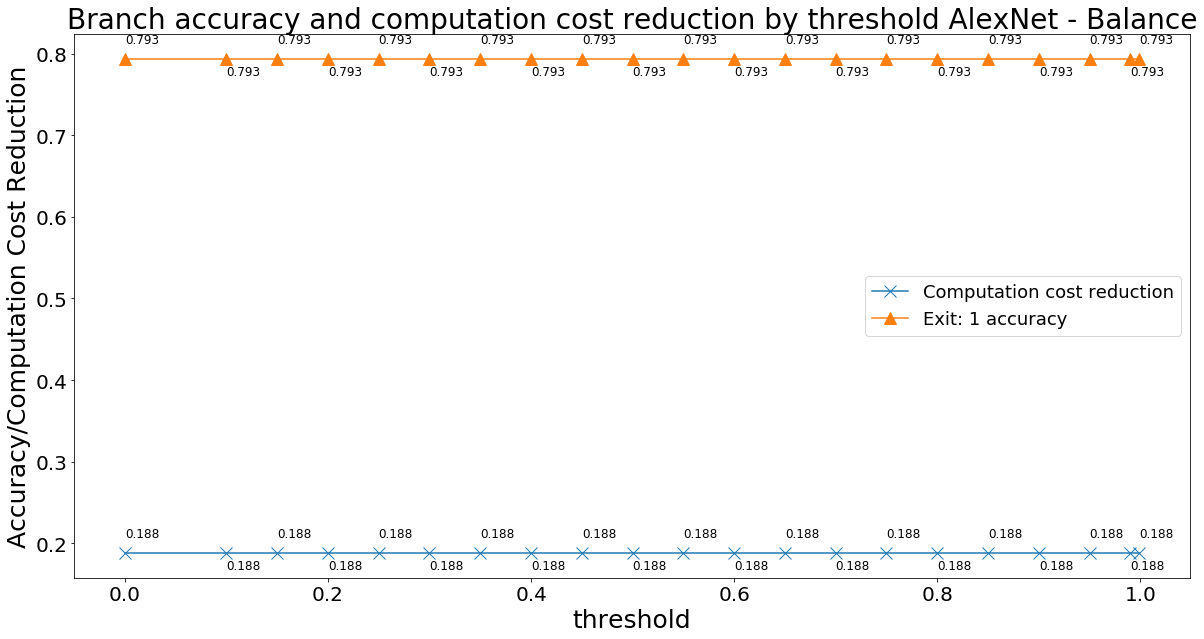

In [117]:
dfList1 = []
dfList2 = []
lossHP = [1.75,33.82]
for net in range(0,2):
    
    
    for lossFunc in range(0,3):
        
        title = ' ' + netsDesc[net] + ' - ' + lossFDesc[lossFunc]
        
        files = fileList(net,lossFunc)
        trainResults = pd.read_csv(files[0],sep='\t')
        testResults = pd.read_csv(files[1],sep='\t')
        evalResults = pd.read_csv(files[2],sep='\t')
        
        ouputFolder = files[3]
        
        
            
        trainResults2 = trainResults[np.isfinite(trainResults['accuracy'])]
        
        if lossFunc == 2:
            
            testResults = testResults[testResults['lossHyP']==lossHP[net]]
            trainResults2  = trainResults2[trainResults2['lossHyP']==lossHP[net]]
            
        renameBranchesName(trainResults2,'path')
        
#         createAndSaveRunningResultsGraph(trainResults2,
#                                          'loss',
#                                          'Train loss vs epoch' + title,
#                                          ouputFolder)
        
#         createAndSaveRunningResultsGraph(trainResults2,
#                                          'accuracy',
#                                          'Train accuracy vs epoch'+ title,
#                                          ouputFolder)
        
        renameBranchesName(testResults,'path')

#         createAndSaveRunningResultsGraph(testResults,
#                                          'accuracy',
#                                          'Test accuracy vs epoch'+ title,
#                                          ouputFolder)
        
#         evalAccuracyAndCertScore(trainResults2,
#                                  ouputFolder,
#                                  'Training accuracy and certainty vs epoch'+ title)
        
#         evalAccuracyAndCertScore(testResults,
#                                  ouputFolder,
#                                  'Test accuracy and certainty vs epoch'+ title)
        
        renameBranchesName(evalResults,'path')
        
        evalResults = evalResults.dropna()
#         casesByExitGraph(evalResults,
#                          'Evaluations precenatge in each exit'+ title,
#                          ouputFolder)
        
        dfAccVsComp = evalAccuracyNoGroundTruth(evalResults,
                                  'Branch accuracy and computation cost reduction by threshold' + title,
                                  ouputFolder)
        if net==0:
            dfList1.append(dfAccVsComp)
        else:
            dfList2.append(dfAccVsComp)
    

In [24]:
lossHP = [1.75,33.82]
dfList1 = []
dfList2 = []
casesPerNet = 10000
totalComputationCost = [15786*10000,153322*10000]

for net in range(0,2):
    for lossFunc in range(0,3):
        
        totalAccByThreshold = {}
        computationCostReductionByThreshold = {}
        
        files = fileList(net,lossFunc)
        trainResults = pd.read_csv(files[0],sep='\t')
        testResults = pd.read_csv(files[1],sep='\t')
        evalResults = pd.read_csv(files[2],sep='\t')
        
        ouputFolder = files[3]
        renameBranchesName(evalResults,'path')
        
        evalResults = evalResults.dropna()
        
        netexits = list(evalResults.exit.unique())
        thresholds = list(evalResults.threshold.unique())
    
        for t in thresholds:
            dfResultsByT = evalResults[evalResults['threshold']==t]
            #calulate the computation cost reduction

            computationCostReduction = 0
            accuracy = 0
            computationCostReduction = 0
            for idx, exit in enumerate(netexits):

                dfResultsByExit = dfResultsByT[dfResultsByT['exit']==exit]

                casesToEval = dfResultsByExit['casesToEval'].mean()
                accuracyToEval = dfResultsByExit['accuracyToEval'].mean()

                accuracy = accuracy+casesToEval*accuracyToEval
                
                pathComputationCost = dfResultsByExit['pathComputationCost'].mean()
                pathCases = dfResultsByExit['casesToEval'].mean()
            
                computationCost = pathComputationCost*pathCases
            
                computationCostReduction = computationCostReduction + computationCost
        
            computationCostReduction = 1 - computationCostReduction/totalComputationCost[net]
            computationCostReductionByThreshold[t] = computationCostReduction
            
            accuracy = accuracy/casesPerNet
            totalAccByThreshold[t] = accuracy
            
        evalResults['combinedAcc'] = evalResults['threshold'].map(totalAccByThreshold)
        evalResults['computationCostReduction'] = evalResults['threshold'].map(computationCostReductionByThreshold)
        
        evalResults = evalResults.append({'exit':1,
                                        'combinedAcc':100,
                                           'computationCostReduction':0}, ignore_index=True)
        
        if net==0:
            dfList1.append(evalResults)
        else:
            dfList2.append(evalResults)

In [22]:
dfList1[0].head()

,Unnamed: 0,threshold,path,pathComputationCost,accuracy,casesToEval,accuracyToEval,casesNotToEval,accuracyNotToEval,exit,combinedAcc,computationCostReduction
0,0.0,0.00,3.0,11625.0,98.72,10000.0,98.72,0.0,0.0,1,98.72,0.263588
1,1.0,0.00,main,15786.0,100.00,0.0,0.00,0.0,0.0,main,98.72,0.263588
2,2.0,0.10,3.0,11625.0,98.72,10000.0,98.72,0.0,0.0,1,98.72,0.263588
3,3.0,0.10,main,15786.0,100.00,0.0,0.00,0.0,0.0,main,98.72,0.263588
4,4.0,0.15,3.0,11625.0,98.72,10000.0,98.72,0.0,0.0,1,98.72,0.263588


C:\Users\yael_\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


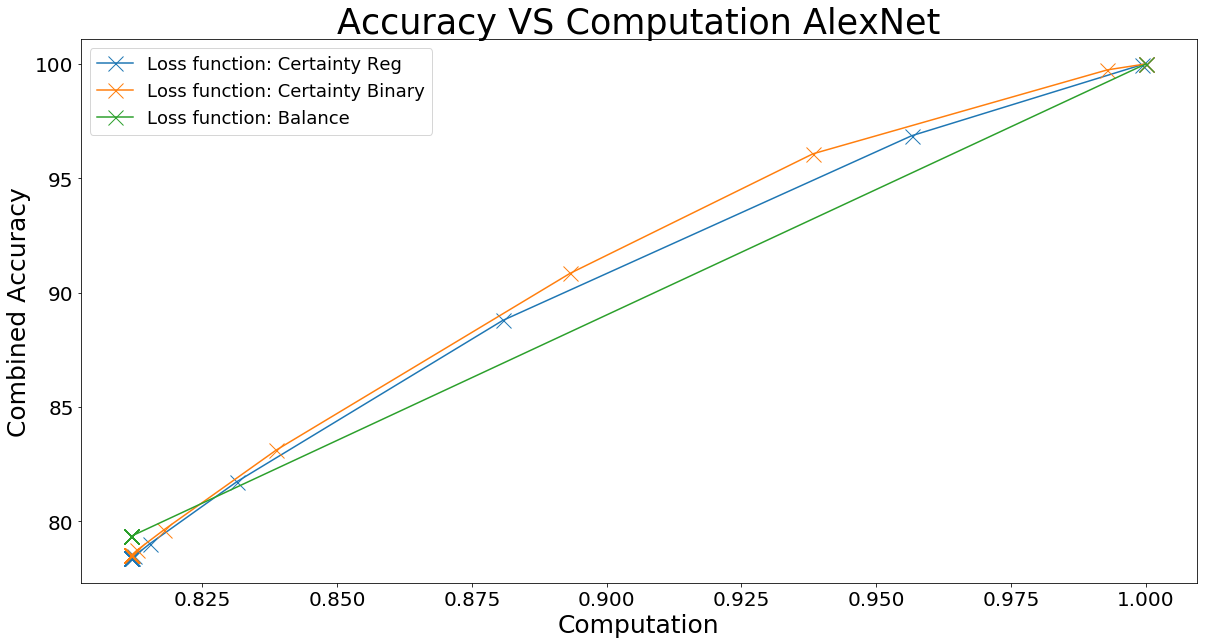

In [28]:
accuracyVsComputation(dfList2,
                      'Accuracy VS Computation' + ' ' + netsDesc[1],
                      'C:\Yael Codes\Pyhton\FinalProject\Results')

C:\Users\yael_\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


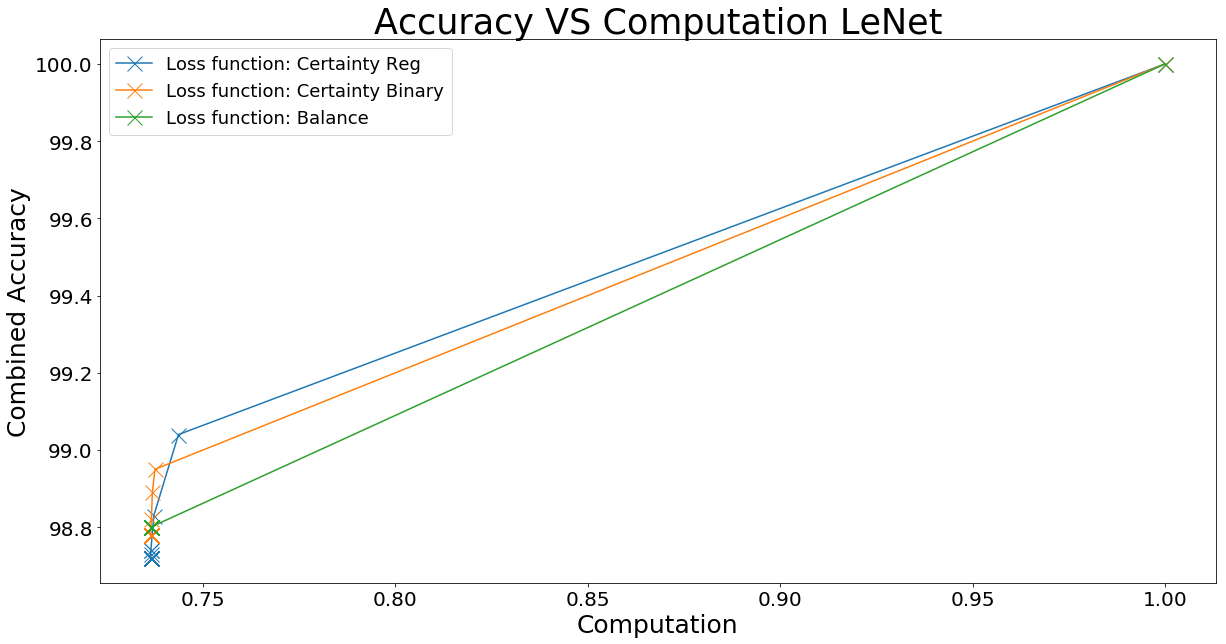

In [29]:
accuracyVsComputation(dfList1,
                      'Accuracy VS Computation' + ' ' + netsDesc[0],
                      'C:\Yael Codes\Pyhton\FinalProject\Results')

In [118]:
dfList1[1].head(20)

,Unnamed: 0,threshold,path,pathComputationCost,accuracy,casesToEval,accuracyToEval,casesNotToEval,accuracyNotToEval,exit,computationCostReduction
0,0,0.00,3.0,11625.0,98.78,10000.0,0.9878,0.0,0.0,1,0.263588
1,1,0.00,main,15786.0,100.00,0.0,1.0000,0.0,0.0,main,0.263588
2,2,0.10,3.0,11625.0,98.78,10000.0,0.9878,0.0,0.0,1,0.263588
3,3,0.10,main,15786.0,100.00,0.0,1.0000,0.0,0.0,main,0.263588
4,4,0.15,3.0,11625.0,98.78,10000.0,0.9878,0.0,0.0,1,0.263588
5,5,0.15,main,15786.0,100.00,0.0,1.0000,0.0,0.0,main,0.263588
6,6,0.20,3.0,11625.0,98.78,10000.0,0.9878,0.0,0.0,1,0.263588
7,7,0.20,main,15786.0,100.00,0.0,1.0000,0.0,0.0,main,0.263588
8,8,0.25,3.0,11625.0,98.78,10000.0,0.9878,0.0,0.0,1,0.263588
9,9,0.25,main,15786.0,100.00,0.0,1.0000,0.0,0.0,main,0.263588


In [119]:
dfList2[2].head(20)

,Unnamed: 0,threshold,path,pathComputationCost,accuracy,casesToEval,accuracyToEval,casesNotToEval,accuracyNotToEval,exit,computationCostReduction
0,0,0.00,main,153322.0,100.00,0.0,1.0000,0.0,0.0,main,0.188114
1,1,0.00,3.0,124480.0,79.35,10000.0,0.7935,0.0,0.0,1,0.188114
2,2,0.10,main,153322.0,100.00,0.0,1.0000,0.0,0.0,main,0.188114
3,3,0.10,3.0,124480.0,79.35,10000.0,0.7935,0.0,0.0,1,0.188114
4,4,0.15,main,153322.0,100.00,0.0,1.0000,0.0,0.0,main,0.188114
5,5,0.15,3.0,124480.0,79.35,10000.0,0.7935,0.0,0.0,1,0.188114
6,6,0.20,main,153322.0,100.00,0.0,1.0000,0.0,0.0,main,0.188114
7,7,0.20,3.0,124480.0,79.35,10000.0,0.7935,0.0,0.0,1,0.188114
8,8,0.25,main,153322.0,100.00,0.0,1.0000,0.0,0.0,main,0.188114
9,9,0.25,3.0,124480.0,79.35,10000.0,0.7935,0.0,0.0,1,0.188114


In [71]:
lossHP = [1.75,33.82]

In [72]:
files = fileList(0,2)
trainResults = pd.read_csv(files[0],sep='\t')
testResults = pd.read_csv(files[1],sep='\t')
evalResults = pd.read_csv(files[2],sep='\t')
        
ouputFolder = files[3]
        
        
            
trainResults2 = trainResults[np.isfinite(trainResults['accuracy'])]

testResults.head()

,Unnamed: 0,epoch,batch,running_exanples,loss,accuracy,path,avgCertainty,certScore,lossHyP
0,0,1.0,NaN,10000.0,0.000362,25.31,3.0,3.303183e-06,74.689971,0.1
1,1,2.0,NaN,20000.0,0.000362,24.61,3.0,1.650550e-06,75.389974,0.1
2,2,3.0,NaN,30000.0,0.000362,24.18,3.0,1.099451e-06,75.819978,0.1
3,3,4.0,NaN,40000.0,0.000362,23.74,3.0,8.275005e-07,76.259981,0.1
4,4,5.0,NaN,50000.0,0.000362,23.47,3.0,6.591338e-07,76.529982,0.1


In [77]:
testResults = testResults[testResults['lossHyP']==lossHP[0]]

In [78]:
testResults.head()

,Unnamed: 0,epoch,batch,running_exanples,loss,accuracy,path,avgCertainty,certScore,lossHyP
200,200,1.0,NaN,10000.0,0.000445,96.19,3.0,0.999957,96.186422,1.75
201,201,2.0,NaN,20000.0,0.000260,97.64,3.0,0.999987,97.638943,1.75
202,202,3.0,NaN,30000.0,0.000236,97.88,3.0,0.999986,97.878918,1.75
203,203,4.0,NaN,40000.0,0.000204,98.14,3.0,0.999985,98.138734,1.75
204,204,5.0,NaN,50000.0,0.000322,97.16,3.0,0.999989,97.159098,1.75


0.0
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001


,accuracyToEval,computationCostReduction
1,1.0,0.263588
3,1.0,0.263588
5,1.0,0.263588
7,1.0,0.263588
9,1.0,0.263588


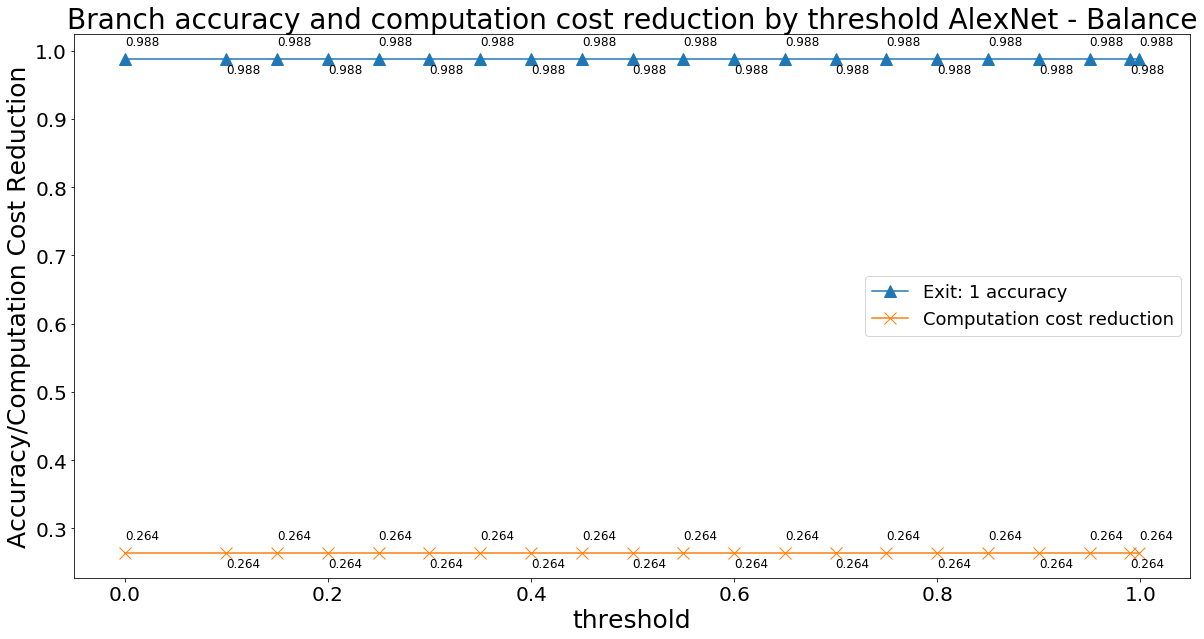

In [80]:
renameBranchesName(evalResults,'path')
        
evalResults = evalResults.dropna()
        
dfAccVsComp = evalAccuracyNoGroundTruth(evalResults,
                                  'Branch accuracy and computation cost reduction by threshold' + title,
                                  ouputFolder)

dfAccVsComp.head()

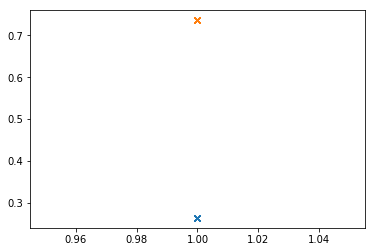

In [85]:
dfAccVsComp.head(30)

plt.plot( 'accuracyToEval', 
          'computationCostReduction', 
           marker="x",
            data=dfAccVsComp)

dfAccVsComp['computation'] = 1-dfAccVsComp['computationCostReduction']
plt.plot( 'accuracyToEval', 
          'computation', 
           marker="x",
            data=dfAccVsComp)

In [51]:
#uplaod files
trainResults = pd.read_csv('C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth\TrainRunning\ExportRunningData 20190412-140641',sep='\t')
testResults = pd.read_csv('C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth\TestRunning\ExportRunningData 20190412-140641',sep='\t')
evalResults = pd.read_csv('C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth\EvalResults\ExportEvalData 20190412-142832',sep='\t')

ouputFolder = 'C:\Yael Codes\Pyhton\FinalProject\Results\Loss function 1 main to certainty\AlexNetBranch no ground truth\Graphs'

1. First set of results

Lenet with one  branch point with ground truth and without ground truth (branch exit is compared to main exit)

In [52]:


print(trainResults.columns.values)
trainResults.head()

['Unnamed: 0' 'epoch' 'batch' 'running_exanples' 'loss' 'accuracy' 'path'
 'avgCertainty' 'certScore' 'lossHyP']


,Unnamed: 0,epoch,batch,running_exanples,loss,accuracy,path,avgCertainty,certScore,lossHyP
0,0,1.0,0.0,0.0,11.428064,NaN,3.0,NaN,NaN,NaN
1,1,1.0,10.0,640.0,10.747639,NaN,3.0,NaN,NaN,NaN
2,2,1.0,20.0,1280.0,10.821241,NaN,3.0,NaN,NaN,NaN
3,3,1.0,30.0,1920.0,10.560127,NaN,3.0,NaN,NaN,NaN
4,4,1.0,40.0,2560.0,11.167571,NaN,3.0,NaN,NaN,NaN


In [53]:
trainResults2 = trainResults[np.isfinite(trainResults['accuracy'])]
trainResults2.head()

,Unnamed: 0,epoch,batch,running_exanples,loss,accuracy,path,avgCertainty,certScore,lossHyP
50,50,1.0,NaN,50000.0,4353.545898,40.030,3.0,0.397618,56.516175,NaN
101,101,2.0,NaN,100000.0,2878.002197,63.056,3.0,0.627270,55.231583,NaN
152,152,3.0,NaN,150000.0,2402.688232,69.534,3.0,0.692129,58.755932,NaN
203,203,4.0,NaN,200000.0,2229.455566,72.020,3.0,0.717385,60.854628,NaN
254,254,5.0,NaN,250000.0,2117.056152,73.652,3.0,0.733876,62.290162,NaN


In [54]:
renameBranchesName(trainResults2,'path')

trainResults2.head()

netexits = list(trainResults2.exit.unique())
print(netexits)

[1]


C:\Users\yael_\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


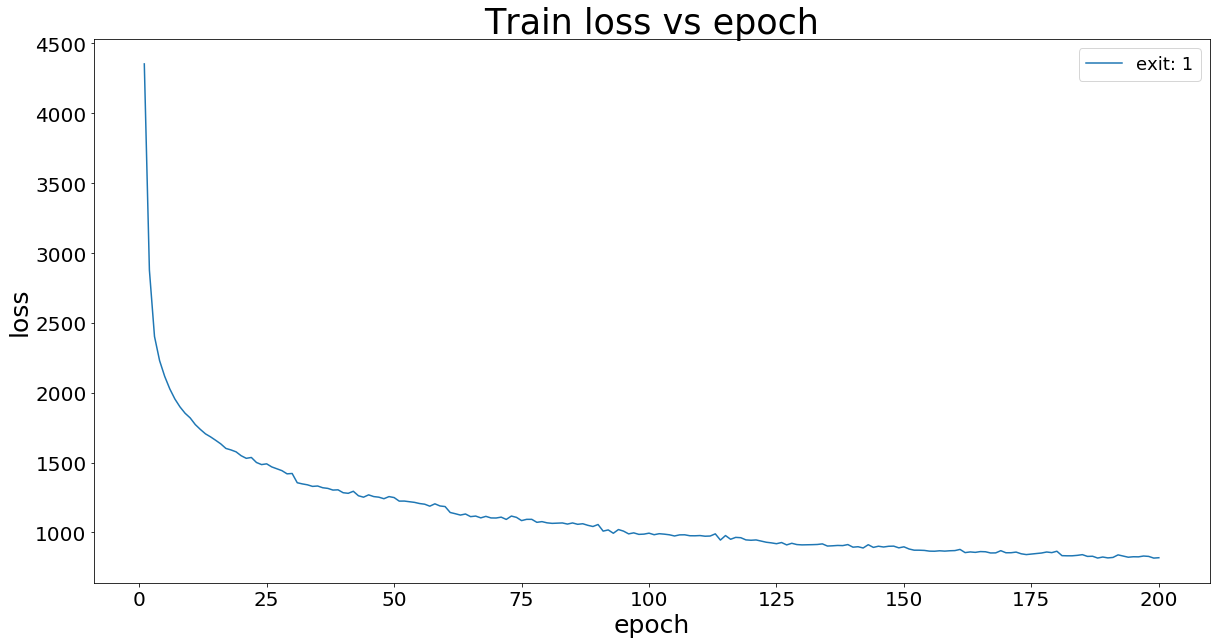

In [55]:
# plt.figure(figsize=(20,10))

# for exit in netexits:
#     trainResultsByexit = trainResults2[trainResults2['exit']==exit]
#     plt.plot( 'epoch', 'loss', data=trainResultsByexit, label='exit: ' + str(exit))

# plt.xlabel('epoch', fontsize=18)
# plt.ylabel('loss', fontsize=18)
# plt.title('Train loss vs epoch', fontsize=18)
# plt.legend()


# plt.savefig('LeNetBranch first/Graphs/Train loss vs epoch.png')   # save the figure to file
createAndSaveRunningResultsGraph(trainResults2,'loss','Train loss vs epoch',ouputFolder)
#

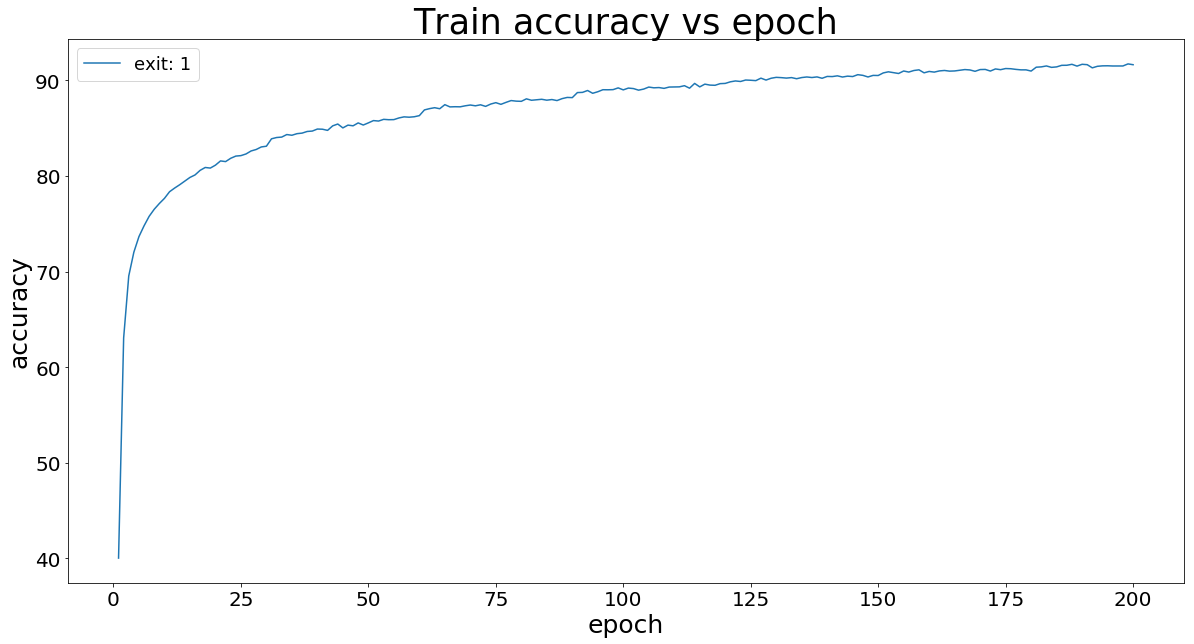

In [56]:
createAndSaveRunningResultsGraph(trainResults2,'accuracy','Train accuracy vs epoch',ouputFolder)

In [57]:

print(testResults.columns.values)
testResults.head()

['Unnamed: 0' 'epoch' 'batch' 'running_exanples' 'loss' 'accuracy' 'path'
 'avgCertainty' 'certScore' 'lossHyP']


,Unnamed: 0,epoch,batch,running_exanples,loss,accuracy,path,avgCertainty,certScore,lossHyP
0,0,1.0,NaN,10000.0,0.067279,56.43,3.0,0.552860,53.948771,NaN
1,1,2.0,NaN,20000.0,0.050546,67.12,3.0,0.641791,56.014629,NaN
2,2,3.0,NaN,30000.0,0.043496,72.49,3.0,0.727613,61.370448,NaN
3,3,4.0,NaN,40000.0,0.042395,73.15,3.0,0.722851,61.633434,NaN
4,4,5.0,NaN,50000.0,0.040248,75.15,3.0,0.744759,63.466354,NaN


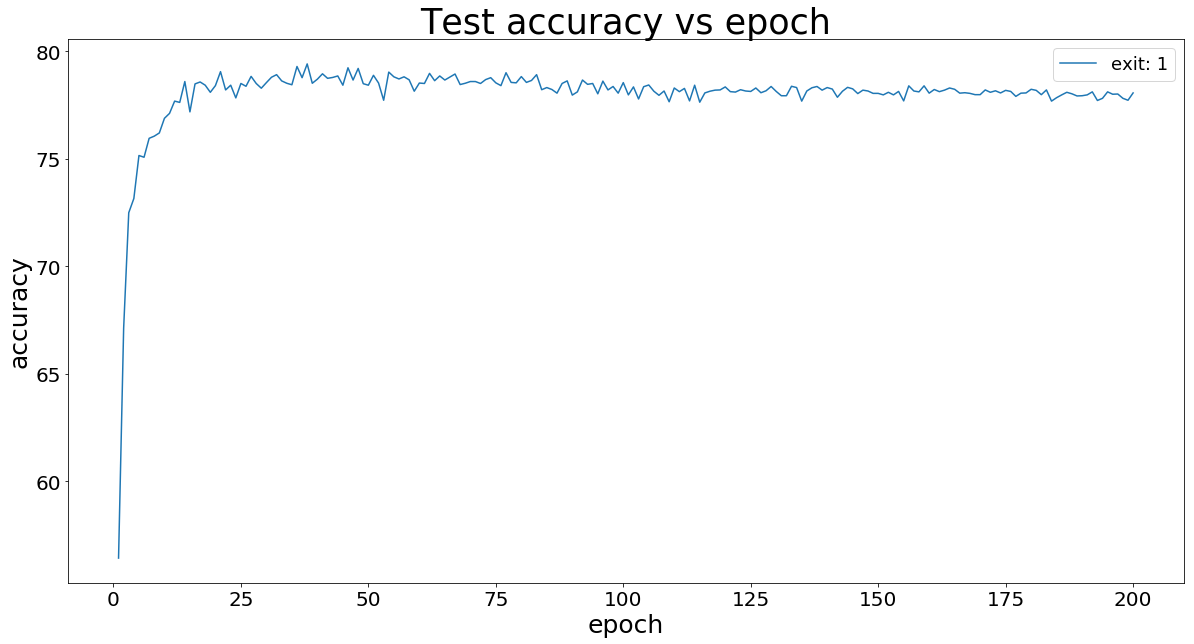

In [58]:
renameBranchesName(testResults,'path')

#createAndSaveRunningResultsGraph(testResults,'loss','Overall test loss vs epoch')
createAndSaveRunningResultsGraph(testResults,'accuracy','Test accuracy vs epoch',ouputFolder)


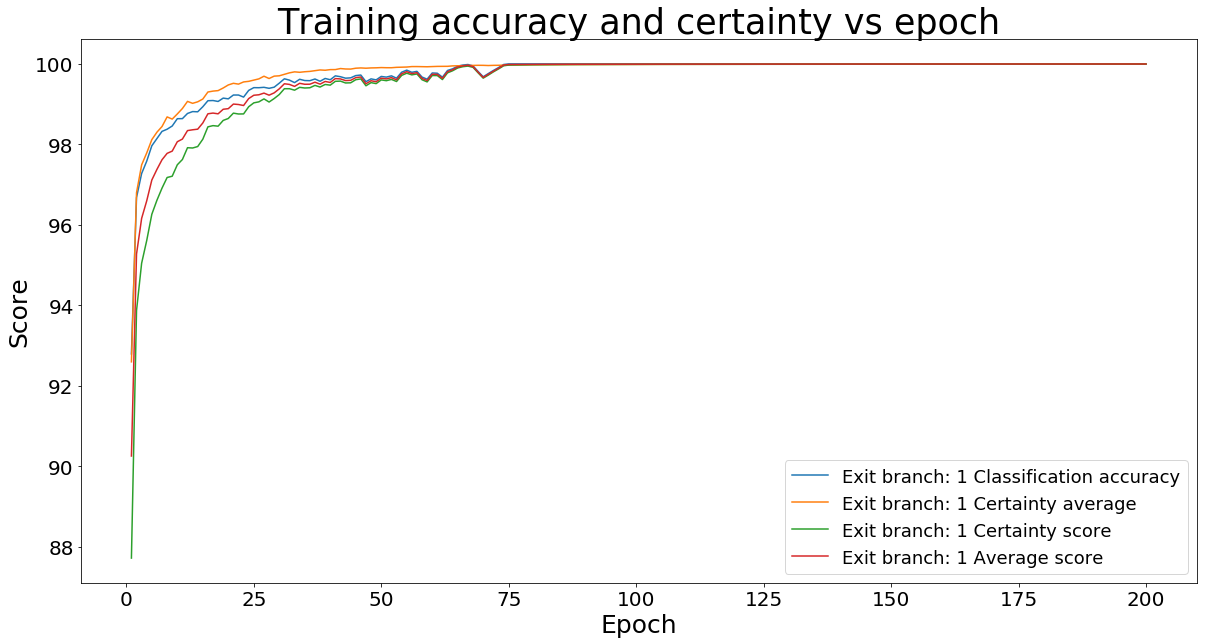

In [50]:
evalAccuracyAndCertScore(trainResults2,ouputFolder,'Training accuracy and certainty vs epoch')

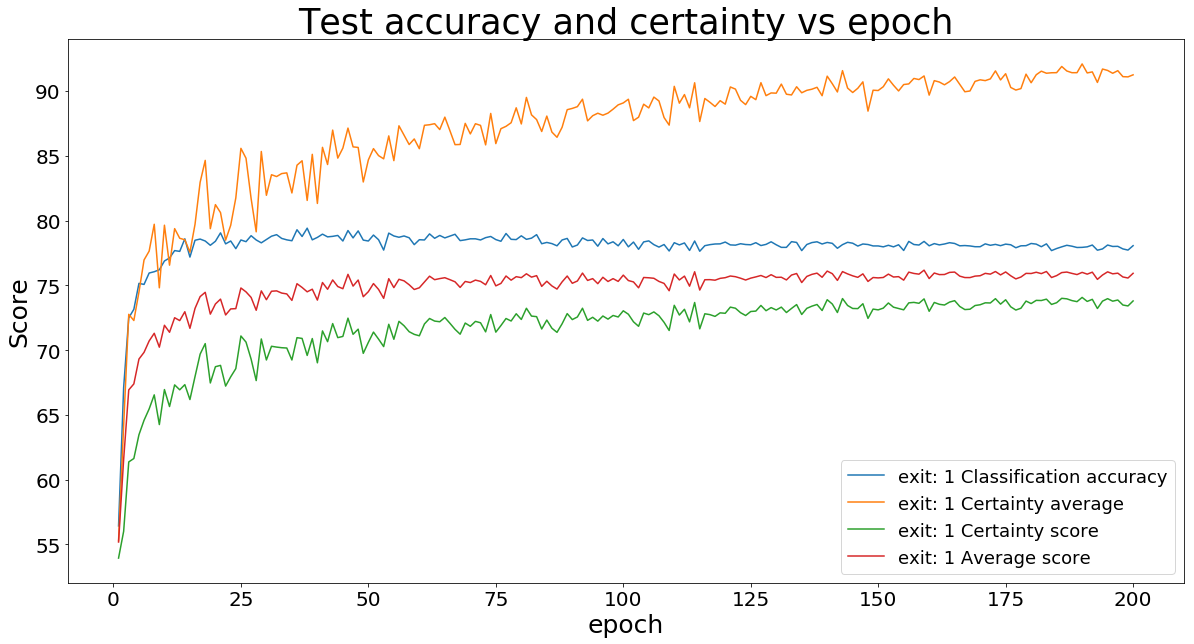

In [60]:
evalAccuracyAndCertScore(testResults,ouputFolder,'Test accuracy and certainty vs epoch')

In [61]:

print(evalResults.columns.values)
evalResults.head()

['Unnamed: 0' 'threshold' 'path' 'pathComputationCost' 'accuracy'
 'casesToEval' 'accuracyToEval' 'casesNotToEval' 'accuracyNotToEval']


,Unnamed: 0,threshold,path,pathComputationCost,accuracy,casesToEval,accuracyToEval,casesNotToEval,accuracyNotToEval
0,0,0.3,main,153322.0,100.00,0.0,0.00,0.0,0.0
1,1,0.3,3.0,124480.0,78.39,10000.0,78.39,0.0,0.0
2,2,0.4,main,153322.0,100.00,0.0,0.00,0.0,0.0
3,3,0.4,3.0,124480.0,78.39,10000.0,78.39,0.0,0.0
4,4,0.5,main,153322.0,100.00,0.0,0.00,0.0,0.0


In [62]:
#Exit by path
#evalResults['exit'] = evalResults['path']
renameBranchesName(evalResults,'path')
#evalResults['casesToEval'] = evalResults['casesToEval']*100/10000

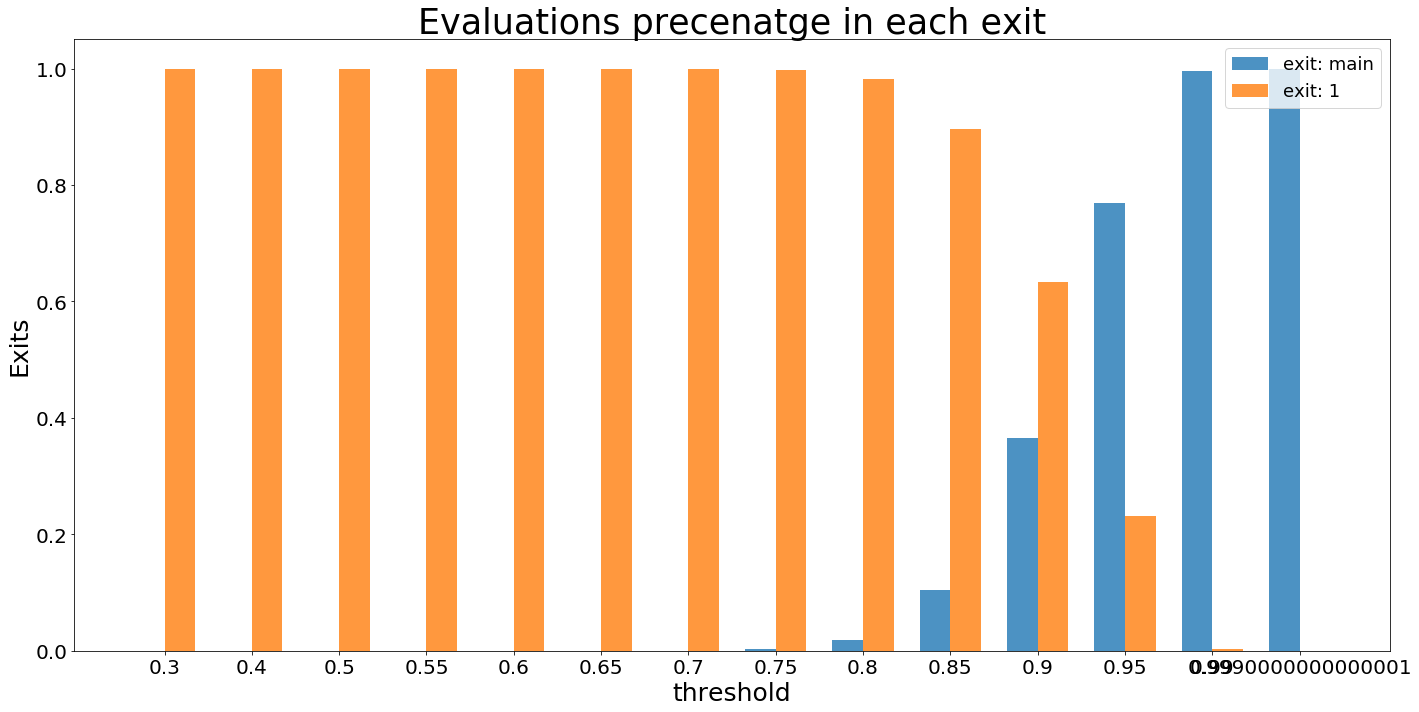

In [63]:

evalResults = evalResults.dropna()
casesByExitGraph(evalResults,ouputFolder)

In [64]:
netexits = list(evalResults.exit.unique())
thresholds = list(evalResults.threshold.astype(str).unique())
    
index = np.arange(len(thresholds))
    
print(thresholds)
for exit in netexits:
    dfResultsByexit = evalResults[evalResults['exit']==exit]
    print(len(dfResultsByexit))
    

['0.3', '0.4', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95', '0.99', '0.9990000000000001']
14
14


0.3
0.4
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
0.99
0.9990000000000001


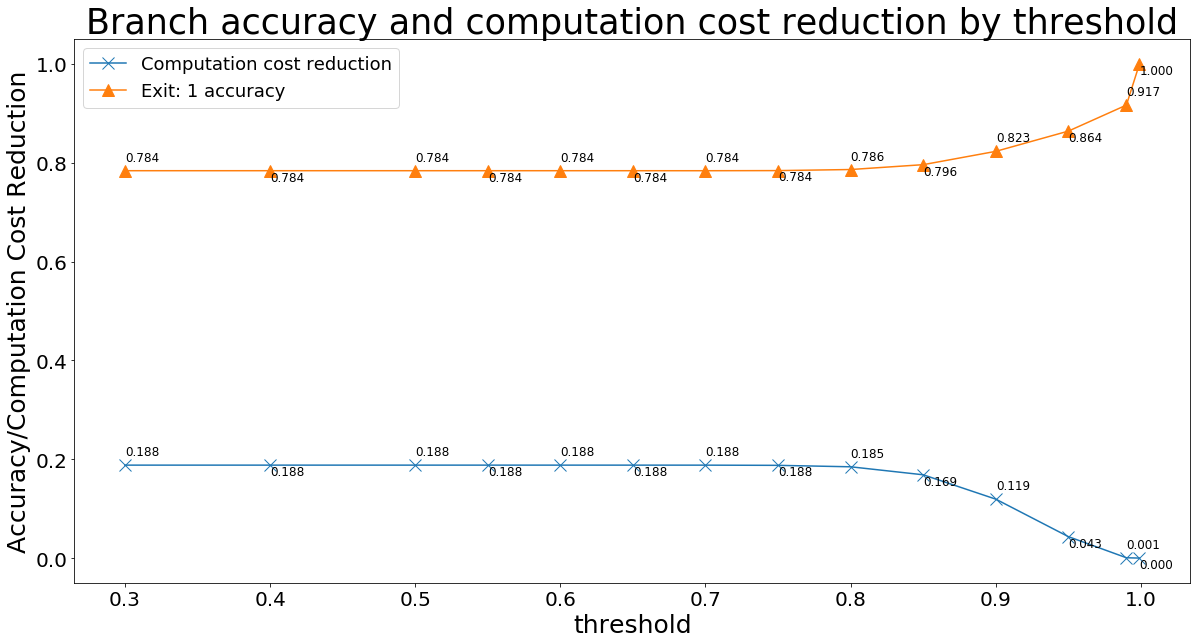

In [65]:
evalAccuracyNoGroundTruth(evalResults,ouputFolder)

In [ ]:
    
    
#     #dfResults2.head(30)
#     print(computationCostReductionByThreshold)
#     print(totalComputationCost)
#     print(casesTotal)

In [ ]:
#dfResults2.head(30)